# A.- Preparación de los datos

### 1.- División entre datos de entrenamiento y datos de prueba.

In [3]:
'''python
Preparación de datos de entrenamiento y de prueba.
'''

# Importamos las librerías a usar.

# De uso general.
import pandas as pd
import numpy as np

# Para mostrar gráficos.
import matplotlib.pyplot as plt
import seaborn as sns

# Para separar datos de entrenamiento y pruebas.
from sklearn.model_selection import train_test_split

# Para la transformación de los datos.
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Para la selección de características.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


In [4]:
# Cargamos los datos.
df = pd.read_csv('bank_dataset.csv')

# Seleccionamos las características.
X = df.loc [:, df.columns.drop ('deposit')]

# Nuestra variable objetivo.
Y = df.loc [:, ['deposit']]

# Dividimos en datos de entramiento y datos de prueba
Xtrain, Xtest, Ytrain, Ytest = train_test_split (X, Y, test_size = 0.3, random_state = 1, stratify = Y)

# Salvamos los datos.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv  ('bank_test.csv', index = False)
Ytrain.to_csv ('bank_target_train.csv', index = False)
Ytest.to_csv  ('bank_target_test.csv', index = False)


### 2.- Imputación de Valores Faltantes.

#### 2.1.- Mediante la media y la moda.

Se encuentran muy pocos valores nulos, localizados en las columnas "age", "marital" y "status".

Rellenamos los datos nulos de "age" mediante la media.

In [9]:
# "age" mean
age_mean = X ['age'].mean ()

# Para los valores de entrenamiento
Xtrain.loc [Xtrain ['age'].isnull(), 'age'] = age_mean

# Para los valores de prueba
Xtest.loc [Xtest ['age'].isnull(), 'age'] = age_mean

# Salvamos los datos.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


Rellenamos los datos nulos de "marital" y "education" con la moda, en función de la edad, mediante la definición de un conjunto de intervalos.

In [11]:
# En 'marital' y 'education' sustituiremos los valores faltantes por la moda, en función de la edad.

# Definimos una tupla para diferentes intervalos en 'age': 0 - 18, 18 - 25, 25 - 45, 45 - 65 y > 65.
tpl_age = (0, 18, 25, 45, 65)

# Calculamos la moda para cada intervalo y la salvamos en una lista.
def mode_by_age (df, col):
    lst_mode = []

    for i in range (len (tpl_age) - 1):
        # print ("i ", i)
        df_age = df.loc [(df ['age'] > tpl_age [i]) & (df ['age'] <= tpl_age [i + 1]), :]
        # print (df_age)
        if not df_age.empty:
            lst_mode.append (df_age [col].mode () [0])
        else:
            lst_mode.append (-1)

    df_age = df.loc [(df ['age'] > tpl_age [i + 1])]
    if not df_age.empty:
        lst_mode.append (df_age [col].mode () [0])
    else:
        lst_mode.append (-1)

    return lst_mode

# Rellenamos los valores faltantes con la moda, en función del intervalo de edad.
def missing_by_age (df, col):

    faltan = df[col].isnull ().sum ()

    if faltan == 0:
        print ("Faltantes (", col, "): ", faltan)
        # print ("return")
        return
    
    print ("Faltantes (", col, "): ", faltan)

    lst_mode = mode_by_age (df, col)

    for i in range (len (tpl_age) - 1):
        df.loc [(df ['age'] > tpl_age [i]) & (df ['age'] <= tpl_age [i + 1]), [col]] = df.fillna ({col: lst_mode [i]})

    i += 1
    df.loc [(df ['age'] > tpl_age [i]), [col]] = df.fillna ({col: lst_mode [i]})

    print ("Faltantes (", col, "): ", df[col].isnull ().sum ())

# Rellenamos los valores faltantes llamando a 'missing_by_age'.

# Para los valores de entrenamiento
missing_by_age (Xtrain, 'marital')
missing_by_age (Xtrain, 'education')

# Para los valores de prueba
missing_by_age (Xtest, 'marital')
missing_by_age (Xtest, 'education')


Faltantes ( marital ):  5
Faltantes ( marital ):  0
Faltantes ( education ):  5
Faltantes ( education ):  0
Faltantes ( marital ):  0
Faltantes ( education ):  2
Faltantes ( education ):  0


#### 2.2.- Mediante asignación de valores.

En el archivo .csv aparecen muchas filas con el valor "other" en la columna "poutcome". Imputaremos dichos datos con el valor 'failure'.

In [14]:
# Para los valores de entrenamiento.

# En la columna 'poutcome', 'other' será sustituido por 'failure'
# Xtrain.loc [Xtrain ['poutcome'] == 'other', 'poutcome'] = 'failure'

# Para los valores de prueba
# En la columna 'poutcome', 'other' será sustituido por 'failure'
# Xtest.loc [Xtest ['poutcome'] == 'other', 'poutcome'] = 'failure'

# Salvamos los datos.
# Xtrain.to_csv ('bank_train.csv', index = False)
# Xtest.to_csv ('bank_test.csv', index = False)


### 3.- Identificación de las Características más Relevantes.

Dado que los datos de entrenamiento son seleccionados al azar, se requiere reevaluar las características más relevantes.
Nótese que en este apartado no se modican ni los datos de entrenamiento ni los de prueba, solo se obtiene la matriz de correlación y una serie de "scores".

#### 3.1.- Matriz de Correlación.

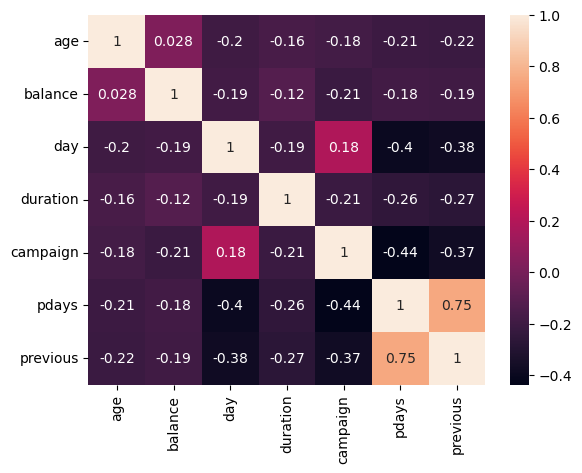

In [18]:
# Creamos la matriz de correlación.

# Cargamos los datos de entrenamiento.
Xt_cont = pd.read_csv ('bank_train.csv')

# Tomamos las características numéricas.
Xt_cont = Xt_cont.loc [:, ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]

# Creamos la matriz de correlación.
corrM = Xt_cont.corr ()

ax = sns.heatmap (corrM.corr(), annot = True)

En la matriz de correlaciones las características "pdays" y "previous" parecen tener una correlación fuerte, eliminaremos "previous".

#### 3.2.- Identificación de Variables Numéricas.

Calcularemos un "score" para las variables numéricas mediante ANOVA.

Para las variables numéricas:
Feature ( duration ): 2093.88
Feature (    pdays ):  180.15
Feature ( previous ):  137.83
Feature ( campaign ):  115.62
Feature (  balance ):   46.00
Feature (      day ):   27.13
Feature (      age ):   14.92


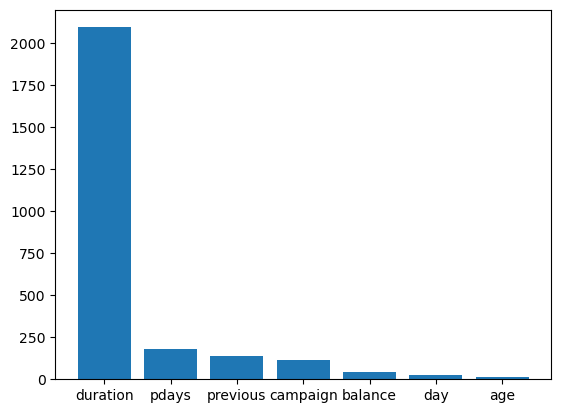

In [22]:
# Primero seleccionamos las variables continuas.

dfX = pd.read_csv('bank_train.csv')
dfY = pd.read_csv('bank_target_train.csv')

# Definimos las variables numéricas.
cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Seleccionamos las variables numéricas.
dfX = dfX.loc [:, cols]

# La función "SelectKBest" acepta arrays de numpy.
np_X = dfX.values
np_Y = dfY.values
np_Y = np.ravel (np_Y, order = 'C')

# Aplicamos el test ANOVA.
fs = SelectKBest (score_func = f_classif, k = 'all')
fs.fit (np_X, np_Y)
np_X = fs.transform (np_X)

# Imprimimos el "score".
print ("Para las variables numéricas:")

# Creamos un dataframe para reordernar los datos.
scr_dict = {'feature': cols, 'score': list (fs.scores_)}
df_Scr = pd.DataFrame (scr_dict).sort_values ('score', ascending = False).reset_index (drop = True)

for i in range (len (fs.scores_)):
    print ('Feature ( %8s ): %7.2f' % (df_Scr.loc [i, 'feature'], df_Scr.loc [i, 'score']))

# Mostramos un histograma con el "score".
plt.bar (df_Scr.loc [:, 'feature'], df_Scr.loc [:, 'score'])
plt.show()

Como se ve, las características más relevantes son "pdays", "previous" y "campaign". Le siguen, en menor medida, "balance", "day" y "age".

Dado que no se conoce la duración de la llamada durante el entrenamiento del modelo, la variable "duration" no podrá utilizarse como característica del modelo, a pesar de mostrar una fuerte correlación con "deposit".

Finalmente la variable "day" está definida como el "dia de la semana" en el que se realizó el contacto. Pero sus valores van del 1 al 31, no del 1 al 7, como podríamos esperar. Aún aceptando que fueran los días del mes, no disponemos del año en el que se realizó la campaña, luego no podemos imputar dichos valores a un día de la semana. Más aún, esta variable debería ejercer poca influencia en la predicción, como se comprueba en el gráfico.

#### 3.3.- Identificación de Variables Categóricas.

Calcularemos un "score" para las variables continuas mediante el test "Chi cuadrado".

Para las variables categóricas:
Feature (   contact ): 622.38
Feature (   housing ): 175.02
Feature (      loan ):  70.34
Feature (       job ):  60.95
Feature (  poutcome ):  46.90
Feature ( education ):  33.02
Feature (   marital ):   8.73
Feature (     month ):   8.10
Feature (   default ):   7.21


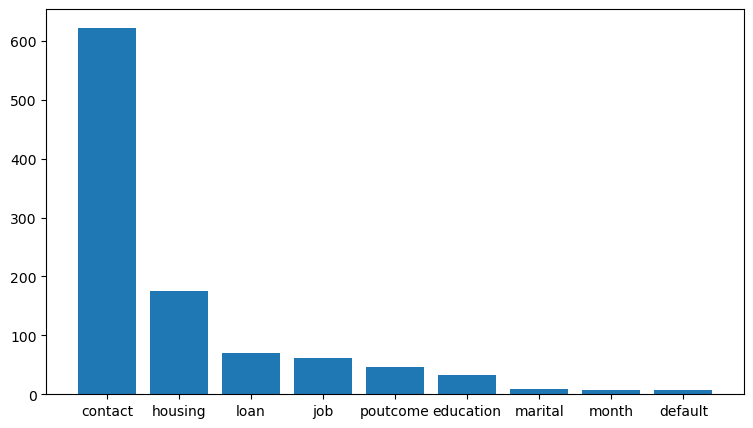

In [28]:
# Después seleccionamos las variables categóricas.

dfX = pd.read_csv('bank_train.csv')
dfY = pd.read_csv('bank_target_train.csv')

# Definimos las variables categóricas.
cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Convertimos las variables categóricas al tipo correcto.
convert_dict = {'job':      'category',
               'marital':   'category',
               'education': 'category',
               'default':   'category',
               'housing':   'category',
               'loan':      'category',
               'contact':   'category',
               'month':     'category',
               'poutcome':  'category'
               }

dfX = dfX.astype (convert_dict)
dfX = dfX.loc [:, cols]

# Asignamos valores enteros a las características y a la salida.
le = LabelEncoder ()
for col in dfX.select_dtypes (include='category').columns:
   dfX [col] = le.fit_transform (dfX [col])

for col in dfY.select_dtypes(include='category').columns:
   dfY [col] = le.fit_transform (dfY [col])

# La función "SelectKBest" acepta arrays de numpy.
np_X = dfX.values
np_Y = dfY.values
np_Y = np.ravel (np_Y, order = 'C')

# Aplicamos el test chi cuadrado.
fs = SelectKBest (score_func = chi2, k = 'all')
fs.fit (np_X, np_Y)
np_X = fs.transform (np_X)

# Imprimimos el "score".
print; print ("Para las variables categóricas:")

# Creamos un dataframe para reordernar los datos.
scr_dict = {'feature': cols, 'score': list (fs.scores_)}
df_Scr = pd.DataFrame (scr_dict).sort_values ('score', ascending = False).reset_index (drop = True)

for i in range (len (fs.scores_)):
    print ('Feature ( %9s ): %6.2f' % (df_Scr.loc [i, 'feature'], df_Scr.loc [i, 'score']))

# Mostramos un histograma con el "score".
plt.figure (figsize = (9, 5))
plt.bar (df_Scr.loc [:, 'feature'], df_Scr.loc [:, 'score'])
plt.show ()


Las características más relevantes son "contact", "housing", "loan", "poutcome", "job" y "education". Algo menos relevantes son "marital", "default" y "month".

### 4.- Codificación de Variables Categóricas.

En la sección anterior se realizó el test "Chi cuadrado" a las características categóricas. Las más relevantes son "contact", "housing", "loan", "poutcome", "job" y "education". Algo menos relevantes son "marital", "default" y "month". Pasamos "OneHotEncoder" a "job" y "education". Por otro lado, "contact", "housing", "loan", "poutcome" y "default" son binarias y podemos aplicar "LabelEnconder".

Para no aumentar demasiado la dimensionalidad, descartamos "marital" y "month", con un "score" bajo.

In [33]:
# Para los valores de entrenamiento.

# Reducimos el número de categorías de 'job', para evitar un aumento en la dimensionalidad.
# Es más simple hacerlo con el tipo 'object'.

# We turn all values into: 'non-qualified', 'semi-qualified', 'qualified', 'freelance' and 'other'.
Xtrain.loc [Xtrain ['job'] == 'housemaid',     ['job']] = 'non-qualified'
Xtrain.loc [Xtrain ['job'] == 'blue-collar',   ['job']] = 'non-qualified'

Xtrain.loc [Xtrain ['job'] == 'admin.',        ['job']] = 'semi-qualified'
Xtrain.loc [Xtrain ['job'] == 'services',      ['job']] = 'semi-qualified'

Xtrain.loc [Xtrain ['job'] == 'management',    ['job']] = 'qualified'
Xtrain.loc [Xtrain ['job'] == 'technician',    ['job']] = 'qualified'

Xtrain.loc [Xtrain ['job'] == 'self-employed', ['job']] = 'freelance'
Xtrain.loc [Xtrain ['job'] == 'entrepreneur',  ['job']] = 'freelance'

# Definimos 'retired', 'student', 'unemployed' y 'unknown' como 'other'.
Xtrain.loc [Xtrain ['job'] == 'retired',    ['job']] = 'other'
Xtrain.loc [Xtrain ['job'] == 'student',    ['job']] = 'other'
Xtrain.loc [Xtrain ['job'] == 'unemployed', ['job']] = 'other'
Xtrain.loc [Xtrain ['job'] == 'unknown',    ['job']] = 'other'

# Asignamos el tipo 'category' a las columnas 'object'.
for col in Xtrain.select_dtypes (include='object').columns:
    Xtrain [col] = Xtrain [col].astype ('category')

# Comprobamos el número de valores de 'job'.
print (Xtrain ['job'].cat.categories)

# Columnas binarias.
cols = ['contact', 'poutcome', 'housing', 'loan', 'default']

le = LabelEncoder ()
for c in cols:
    Xtrain [c] = le.fit_transform (Xtrain[c])

print (Xtrain.info ())
print (Xtrain.loc [:, ['contact', 'poutcome', 'housing', 'loan', 'default']].head ())

# Columnas categóricas.
Xtrain = pd.get_dummies (Xtrain, columns = ['job', 'education'])

# Para los valores de prueba.

# Reducimos el número de categorías de 'job', para evitar un aumento en la dimensionalidad.
# Es más simple hacerlo con el tipo 'object'.
Xtest.loc [Xtest ['job'] == 'housemaid',   ['job']] = 'non-qualified'
Xtest.loc [Xtest ['job'] == 'blue-collar', ['job']] = 'non-qualified'

Xtest.loc [Xtest ['job'] == 'admin.',        ['job']] = 'semi-qualified'
Xtest.loc [Xtest ['job'] == 'services',      ['job']] = 'semi-qualified'

Xtest.loc [Xtest ['job'] == 'management',    ['job']] = 'qualified'
Xtest.loc [Xtest ['job'] == 'technician',    ['job']] = 'qualified'

Xtest.loc [Xtest ['job'] == 'self-employed', ['job']] = 'freelance'
Xtest.loc [Xtest ['job'] == 'entrepreneur',  ['job']] = 'freelance'

# Definimos 'retired', 'student', 'unemployed' y 'unknown' como 'other'.
Xtest.loc [Xtest ['job'] == 'retired',    ['job']] = 'other'
Xtest.loc [Xtest ['job'] == 'student',    ['job']] = 'other'
Xtest.loc [Xtest ['job'] == 'unemployed', ['job']] = 'other'
Xtest.loc [Xtest ['job'] == 'unknown',    ['job']] = 'other'

# Asignamos el tipo 'category' a las columnas 'object'.
for col in Xtest.select_dtypes (include='object').columns:
    Xtest [col] = Xtest [col].astype ('category')

# Comprobamos el número de valores de 'job'.
print (Xtest ['job'].cat.categories)

# Columnas binarias.
# 'cols' está definido arriba.
le = LabelEncoder ()
for c in cols:
    Xtest [c] = le.fit_transform (Xtest [c])

# Columnas categóricas.
Xtest = pd.get_dummies (Xtest, columns = ['job', 'education'])

# print (Xtest.info ())
# print (Xtest.loc [:, ['contact', 'poutcome', 'housing', 'loan', 'default']].head ())

# Salvamos los datos.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


Index(['freelance', 'non-qualified', 'other', 'qualified', 'semi-qualified'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 7813 entries, 2681 to 6257
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        7813 non-null   float64 
 1   job        7813 non-null   category
 2   marital    7813 non-null   category
 3   education  7813 non-null   category
 4   default    7813 non-null   int64   
 5   balance    7813 non-null   int64   
 6   housing    7813 non-null   int64   
 7   loan       7813 non-null   int64   
 8   contact    7813 non-null   int64   
 9   day        7813 non-null   int64   
 10  month      7813 non-null   category
 11  duration   7813 non-null   int64   
 12  campaign   7813 non-null   int64   
 13  pdays      7813 non-null   int64   
 14  previous   7813 non-null   int64   
 15  poutcome   7813 non-null   int64   
dtypes: category(4), float64(1), int64(11)
memory usage: 1.1 MB

### 5.- Estandarización.

En la sección 3, se realizó el test "ANOVA" a las características numéricas. Las más relevantes son "age", "balance", "campaign", "pdays" y "previous". Normalizamos dichas variables. Por otro lado "pdays" y "previous" parecen estar fuertemente correlacionadas, "previous" será descartado.

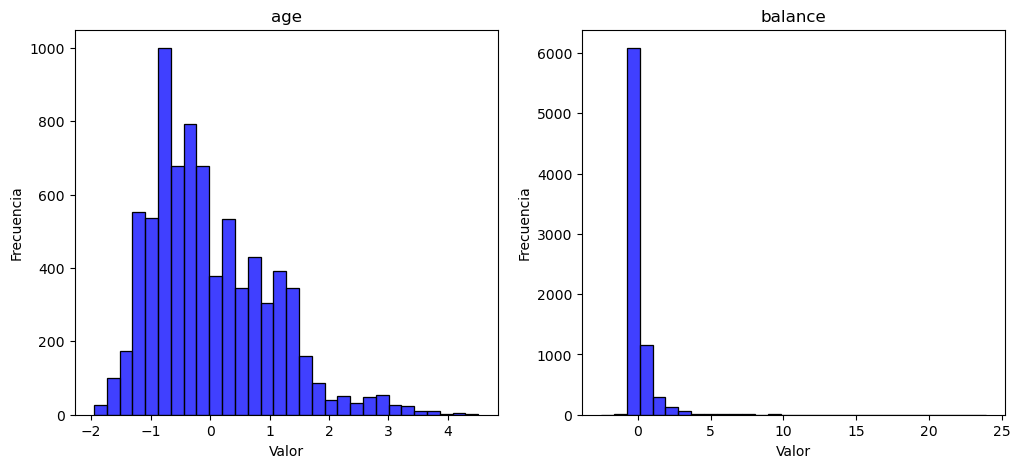

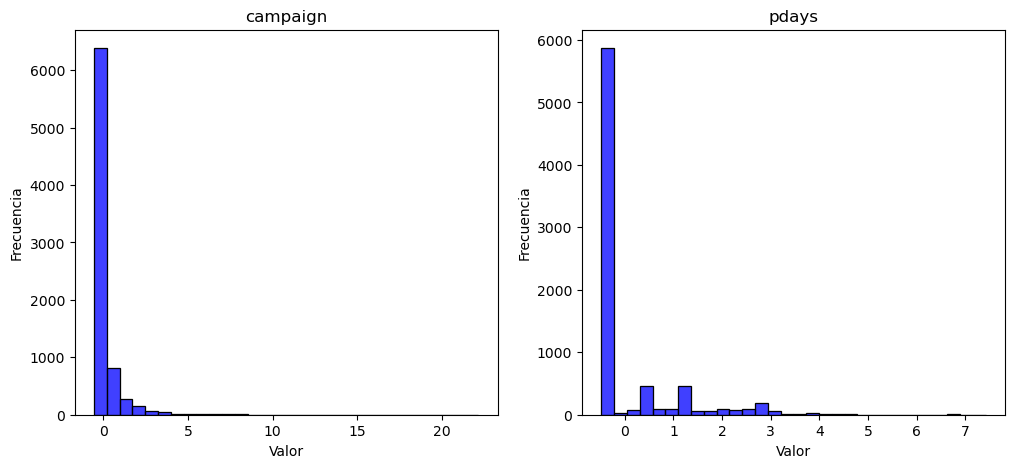

In [36]:
cols = ['age', 'balance', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()

# Para los valores de entrenamiento.
for c in cols:
    Xtrain [c] = Xtrain [c].astype ('float64')

# Aplicamos "fit_transform" a los valores de entrenamiento.
Xtrain.loc [:,cols] = scaler.fit_transform (Xtrain.loc [:,cols])

# Para los valores de prueba.
for c in cols:
    Xtest [c] = Xtest [c].astype ('float64')

# Aplicamos solamente "transform" a los valores de entrenamiento.
Xtest.loc [:,cols] = scaler.transform (Xtest.loc [:,cols])

# Salvamos los datos.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)

# Se muestran los histogramas para comprobar que la media es 0.0 y
# la desvación estándar 1.0.

# Definir las columnas a visualizar.
cols = ['age', 'balance']

fig, axes = plt.subplots (nrows = 1, ncols = 2, figsize = (12, 5))

# Iterar sobre cada columna para crear un histograma
for i, col in enumerate (cols):
    sns.histplot (Xtrain [col], kde = False, ax = axes [i], color = 'blue', bins = 30)
    axes[i].set_title (f'{col}')
    axes[i].set_xlabel ('Valor')
    axes[i].set_ylabel ('Frecuencia')

# Definir las columnas a visualizar
cols = ['campaign', 'pdays']
    
fig, axes = plt.subplots (nrows = 1, ncols = 2, figsize = (12, 5))

# Iterar sobre cada columna para crear un histograma
for i, col in enumerate (cols):
    sns.histplot (Xtrain [col], kde = False, ax = axes [i], color = 'blue', bins = 30)
    axes[i].set_title (f'{col}')
    axes[i].set_xlabel ('Valor')
    axes[i].set_ylabel ('Frecuencia')
    
plt.show()

# Salvamos los datos.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


### 6.- Selección de Características Relevantes.

En la matriz de correlaciones  (Secc. 3) las características "pdays" y "previous" parecen tener una correlación fuerte, eliminamos "previous".

Las características continuas más relevantes son "pdays", "previous" y "campaign". Le siguen, en menor medida, "balance", "day" y "age".

Dado que no se conoce la duración de la llamada durante la predicción, la variable "duration" no podrá utilizarse como característica del modelo, a pesar de mostrar una fuerte correlación con "deposit".

Finalmente la variable "day" está definida como el "dia de la semana" en el que se realizó el contacto. Pero sus valores van del 1 al 31, no del 1 al 7, como podríamos esperar. Aún aceptando que fueran los días del mes, no disponemos del año en el que se realizó la campaña, luego no podemos imputar dichos valores a un día de la semana. Más aún, esta variable debería ejercer poca influencia en la predicción, como se comprueba en el gráfico.

Las características categóricas más relevantes son "contact", "housing", "loan", "poutcome", "job" y "education". Algo menos relevantes son "marital", "default" y "month".

Para no aumentar demasiado la dimensionalidad, descartamos "marital" y "month", con un "score" bajo.

In [44]:
# Para los valores de entrenamiento.

# De las características continuas eliminamos "day", "duration" y "previous".
Xtrain = Xtrain.loc [:, Xtrain.columns.drop (['day', 'duration', 'previous'])]

# De las características categóricas eliminamos "marital" y 'month'.
Xtrain = Xtrain.loc [:, Xtrain.columns.drop (['marital', 'month'])]

# Para los valores de prueba.

# De las características continuas eliminamos "day", "duration" y "previous".
Xtest = Xtest.loc [:, Xtest.columns.drop (['day', 'duration', 'previous'])]

# De las características categóricas eliminamos "marital" y "month".
Xtest = Xtest.loc [:, Xtest.columns.drop (['marital', 'month'])]

print (Xtrain.info ())
print (Xtest.info ())

# Salvamos los datos.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


<class 'pandas.core.frame.DataFrame'>
Index: 7813 entries, 2681 to 6257
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7813 non-null   float64
 1   default              7813 non-null   int64  
 2   balance              7813 non-null   float64
 3   housing              7813 non-null   int64  
 4   loan                 7813 non-null   int64  
 5   contact              7813 non-null   int64  
 6   campaign             7813 non-null   float64
 7   pdays                7813 non-null   float64
 8   poutcome             7813 non-null   int64  
 9   job_freelance        7813 non-null   bool   
 10  job_non-qualified    7813 non-null   bool   
 11  job_other            7813 non-null   bool   
 12  job_qualified        7813 non-null   bool   
 13  job_semi-qualified   7813 non-null   bool   
 14  education_primary    7813 non-null   bool   
 15  education_secondary  7813 non-null   boo

### 7.- Transformaciones de Datos.

En la etapa de EDA se comprueba que las características continuas no muestran distribuciones normales:

"balance" muestra un fuerte sesgo y outliers, será winsorizada.

In [47]:
# Winsorizamos "balance".

# Para los valores de entrenamiento.
Xtrain ['balance'] = winsorize (Xtrain ['balance'], limits = [0.01, 0.1], inplace = True)

# Para los valores de prueba.
Xtest ['balance'] = winsorize (Xtest ['balance'], limits = [0.01, 0.1], inplace = True)

# Salvamos los datos.
Xtrain.to_csv ('bank_train.csv', index = False)
Xtest.to_csv ('bank_test.csv', index = False)


{'whiskers': [<matplotlib.lines.Line2D at 0x7efc502bd460>,
 'caps': [<matplotlib.lines.Line2D at 0x7efc502bd400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efc502ccfb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7efc502bd8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efc502bda00>],
 'means': []}

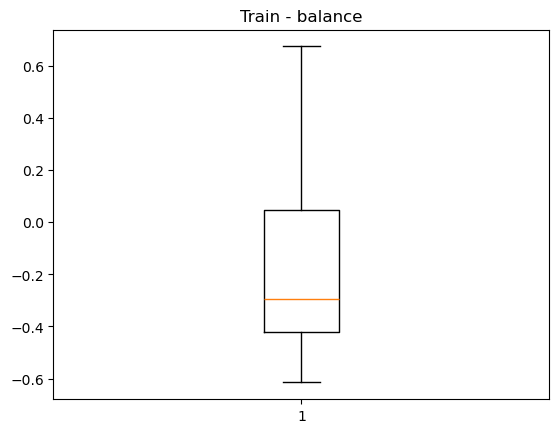

In [48]:
plt.title ("Train - balance")
plt.boxplot (Xtrain ['balance'])

# B.- Entrenamiento del modelo

### 1.- Entrenamiento.

Deseamos predecir si un cliente contratará un depósito a plazo fijo. Así pues escogemos un modelo de clasificación, la regresión logística. Dicho modelo utiliza una función sigmoide para calcular la probabilidad que el cliente contrate el depósito. Para asignar a la variable objetivo 'diposit' su valor, se establece un umbral probabilidad de 0.5. Si el valor de la probabilidad es mayor o igual a 0.5, se asignará el valor 'yes', de lo contrario el valor 'no'.

En el caso que nos ocupa, los falsos positivos, esto es las predicciones positivas que no han contratado el depósito, solo significarán realizar más llamadas. Por el contrario los falsos negativos, las predicciones negativas que sí han contratado el depósito, suponen una pérdida. Expresado de otro modo, los falsos negativos, supondrían una pérdida de contratos. Se minimizará el número de falsos negativos.

Para evaluar nuestro modelo se utilizarán las métricas siguientes:

1. Accuracy score.
2. Precision score.
3. Recall score.
4. f1 score.
5. Curva ROC.


#### 1.1.- Regresión logística y Análisis de sus Métricas.

In [55]:
'''python
Creación, ejecución y evaluación del modelo.
'''

# Para la regresión lgística.
from sklearn.linear_model import LogisticRegression

# Para la evaluación cruzada.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Para los "scores".
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# Para la curva "ROC".
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


Accuracy score:    0.6688563750373245
Precision score:   0.6422619047619048
Recall score:      0.6798991808443604
f1 score:          0.6605448423630241


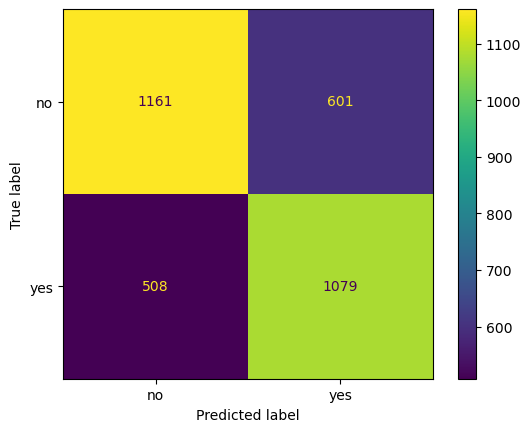

In [56]:

# Cargamos los datos.
Xtrain = pd.read_csv ('bank_train.csv')
Xtest  = pd.read_csv ('bank_test.csv')
ytrain = pd.read_csv ('bank_target_train.csv')
ytest  = pd.read_csv ('bank_target_test.csv')

# Elegimos el modelo, cargamos los datos y lo entrenamos.
logr0 = LogisticRegression ()
logr0.fit (Xtrain, ytrain.to_numpy ().ravel())

# Realizamos nuestra predicción con los valores de prueba.
ypred = logr0.predict (Xtest)

# Mostramos diferentes 'scores'.
print ("Accuracy score:   ", accuracy_score   (ytest, ypred))
print ("Precision score:  ", precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ", recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ", f1_score         (ytest, ypred, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

<class 'numpy.ndarray'>
[[0.80371451 0.19628549]
 [0.39326725 0.60673275]
 [0.2458663  0.7541337 ]
 ...
 [0.36972296 0.63027704]
 [0.40787432 0.59212568]
 [0.54102475 0.45897525]]
Thresholds:  [       inf 0.93685493 0.93376581 ... 0.07275336 0.06944356 0.00687356]


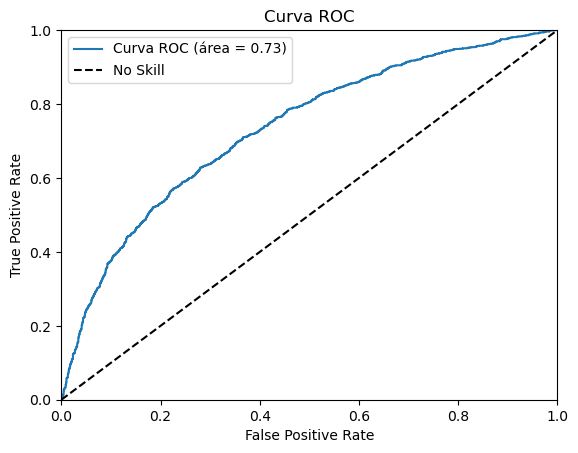

In [57]:
# Dibujamos la curva ROC.

# "logr0" ya está definida.
yproba = logr0.predict_proba (Xtest)

print (type (yproba))
print (yproba)

# Cálculo de la curva.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc (fpr, tpr)

print ("Thresholds: ", thresholds)

# Dibujamos la curva.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()

1. **Accuracy**:

Esta métrica nos da el porcentage de aciertos. Se cuentan tanto verdaderos positivos como verdaderos negativos.

En nuestro caso,

Accuracy = (TP + TN) / N = (1079 + 1161) / 3349 = 0.669 x 100 = 66.9%,

con N = TP + FP + FN + TN = 1161 + 601 + 508 + 1079 = 3349.

Por tanto, el 66% de los clientes será clasicado correctamente, tanto si son positivos como negativos.

El valor es razonable, si bien deja un margen de mejora. Más abajo se relacionan las pruebas realizadas para mejorar las métricas.

2. **Precision**:

Nos ofrece la relación entre auténticos positivos y el total de positivos.

En nuestro caso,

Precison = TP / (TP + FP) = 1079 / (1079 + 601) = 0.642 = 64.2%

Esto es, el 64% de los clientes predichos como positivos han aceptado el contrato.

3. **Recall**:

Esta métrica es particularmente interesante para nuestros propósitos, puesto que es sensible a los falsos negativos.

Se define como el total de verdaderos positivos (TP) dividido entre verdaderos positivos (TP) más falsos negativos (FN).

En nuestro caso:

Recall = TP / (TP + FN) = 1079 / (1079 + 508) = 0.680 = 68.0%

Esto es, nuestra predicción detectará el 68% de todos los positivos reales. Los positivos reales son aquellos que, en efecto, ya han contratado el depósito en el momento de verificar nuestro modelo y que, por tanto, forman parte del conjunto de pruebas.

Como se ha comentado en la introdución, las predicciones negativas que sí han contratado el depósito, suponen una pérdida. Expresado de otro modo, los falsos negativos, supondrían una pérdida de contratos. Se minimizará el número de falsos negativos.

Por tanto optimizando este parámetro disminuiremos el número de falsos negativos. Esto es, evitaremos descartar llamadas a clientes con posibilidades reales de contratar el depósito.

4. **F1**:

Esta métrica es también relevante para nuestro caso, combina las dos métricas anteriores,'precision' y 'recall' para obtener una sola ratio. Se define como:

F = 2·P·R / (P + R)

donde, P es 'precision' y R es 'recall'.

Decimos que es relevante porque en nuestro modelo, al elevar 'recall' disminuyendo el número de falsos negativos, disminuye 'precision'. 'F1 score' nos facilita una ponderación entre ambas métricas.

Para todas las métricas anteriores, tanto más cercanas a 1.0, mejor serán.

Para mejorar las métricas se han realizado las pruebas siguientes:

1. Selección de columnas.
2. Cambio en el número de registros de entrenamiento/prueba.
3. Optimización de hiperparámetros.
4. Validación cruzada.
5. Cambio en el umbral de probabilidad del modelo.
6. Comprobación de diferentes tipos de modelos.

La curva 'ROC' nos servirá para comparar la capacidad de predicción del modelo antes y después de aplicar los cambios.


##### 1.1.1.- **Selección de Columnas.**

Index(['age', 'balance', 'campaign', 'pdays', 'contact', 'default', 'housing',
       'loan', 'poutcome', 'job_non-qualified', 'job_qualified',
       'job_semi-qualified', 'job_freelance', 'job_other', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown'],
      dtype='object')
Accuracy score:    0.6688563750373245
Precision score:   0.6422619047619048
Recall score:      0.6798991808443604
f1 score:          0.6605448423630241


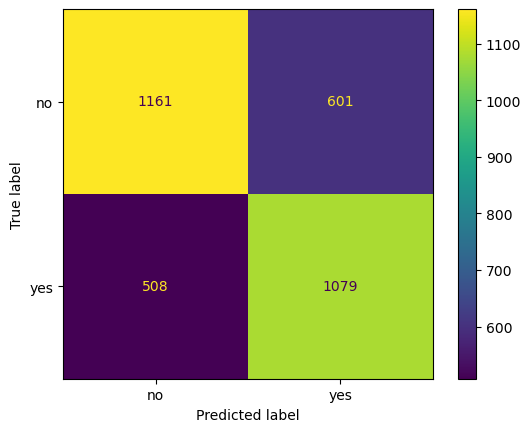

In [62]:

# Cargamos los datos.
Xtrain = pd.read_csv ('bank_train.csv')
Xtest  = pd.read_csv ('bank_test.csv')
ytrain = pd.read_csv ('bank_target_train.csv')
ytest  = pd.read_csv ('bank_target_test.csv')

# Elegimos las columnas que mejoran la predicción del modelo.
# Nótese que si comentamos lineas de código del tipo "cols.extend (['age'])", añadiendo "#" al
# principio de la linea, podemos elegir las características a entrenar.

# El mejor resultado se obtiene eligiendo todas las columnas relevantes seleccionadas en la sección 6.

# Columnas continuas.
cols = []
cols.extend (['age'])
cols.extend (['balance'])
cols.extend (['campaign'])
cols.extend (['pdays'])

# Columnas categóricas.
cols.extend (['contact'])
cols.extend (['default'])
cols.extend (['housing'])
cols.extend (['loan'])
cols.extend (['poutcome'])
cols.extend (['job_non-qualified', 'job_qualified', 'job_semi-qualified', 'job_freelance', 'job_other'])
cols.extend (['education_primary', 'education_secondary', 'education_tertiary', 'education_unknown'])

Xtrain = Xtrain [cols]
Xtest  = Xtest  [cols]

print (Xtrain.columns)

# Elegimos el modelo, cargamos los datos y lo entrenamos.
logr = LogisticRegression ()
logr.fit (Xtrain, ytrain.to_numpy ().ravel())

# Realizamos nuestra predicción con los valores de prueba.
ypred = logr.predict (Xtest)

# Mostramos diferentes 'scores'.
print ("Accuracy score:   ", accuracy_score   (ytest, ypred))
print ("Precision score:  ", precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ", recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ", f1_score         (ytest, ypred, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

El mejor resultado se obtiene eligiendo todas las columnas relevantes seleccionadas en la sección 6.

1.1.2.- **Optimización de Hiperparámetros.**

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Parámetros óptimos:  LogisticRegression(class_weight='balanced', random_state=10, solver='newton-cg')
Accuracy score:    0.6613914601373544
Precision score:   0.6228974498100922
Recall score:      0.7233774417139256
f1 score:          0.6693877551020408


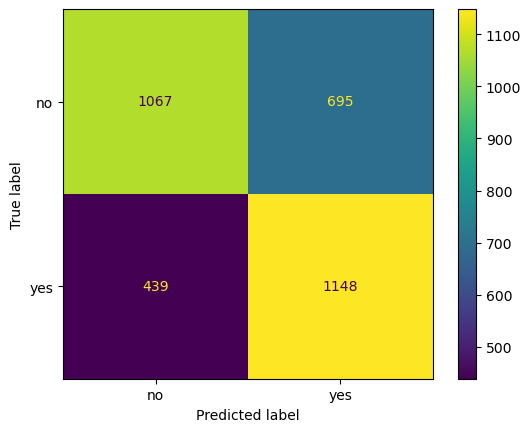

In [65]:
# Optimizamos los hiperparámetros mediante 'grid search'.

# Añadimos 'max_iter', 'solver' y 'class_weight'
param_grid_lr = {
    'max_iter': [100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],   
    'class_weight': ['balanced']                                    
}

# Configuramos nuestro 'grid search' para una valoración cruzada con 10 'folds'.
lr_grid = GridSearchCV (estimator = LogisticRegression (random_state = 10),
                        param_grid = param_grid_lr,
                        verbose = 2, cv = 10, n_jobs = -1)
lr_grid.fit (Xtrain, ytrain.to_numpy ().ravel())

# Obtenemos una predicción.
ypred = lr_grid.predict (Xtest)

# Mostramos los parámetros óptimos.
print ("Parámetros óptimos: ", lr_grid.best_estimator_)

# Mostramos diferentes 'scores'.
print ("Accuracy score:   ", accuracy_score   (ytest, ypred))
print ("Precision score:  ", precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ", recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ", f1_score         (ytest, ypred, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

Mediante 'grid search' el número de falsos negativos se ha reducido de 511 a 442. 'recall' ha mejorado mientras que los demás 'scores' se mantienen.

Los parámetros sugeridos son:

LogisticRegression(class_weight='balanced', random_state=10, solver='liblinear')

1.1.3.- **Validación Cruzada.**

In [68]:

# Definimos nuestros k-folds, con k = 10, y activamos la mezcla ('shuffle') de los datos.
cv = KFold (n_splits = 10, random_state = 1, shuffle = True)

# Creamos el modelo.
lr_K = LogisticRegression (class_weight = 'balanced', random_state = 10, solver = 'newton-cg')

# Para que acepten las categorías '['no', 'yes']', redefinimos los 'scores'.
precision_sc = make_scorer (precision_score, pos_label = 'yes')
recall_sc    = make_scorer (recall_score, pos_label = 'yes')
f1_sc        = make_scorer (f1_score, pos_label = 'yes')

# Obtenemos los diferentes 'scores'.
accuracy  = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = 'accuracy', cv = cv, n_jobs = -1)
precision = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = precision_sc, cv = cv, n_jobs = -1)
recall    = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = recall_sc, cv = cv, n_jobs = -1)
f1        = cross_val_score (lr_K, Xtrain, ytrain.to_numpy ().ravel(), scoring = f1_sc, cv = cv, n_jobs = -1)

# Mostramos los 'scores'.
print ("Accuracy:\n", accuracy)
print ('Mean (std. dev.):  %.3f (%.3f)' % (np.mean (accuracy),  np.std (accuracy)))

print ("\nPrecision:\n", precision)
print ('Mean (std. dev.): %.3f (%.3f)' % (np.mean (precision), np.std (precision)))

print ("\nRecall:\n", recall)
print ('Mean (std. dev.): %.3f (%.3f)' % (np.mean (recall),    np.std (recall)))

print("\nF1:\n", f1)
print('Mean (std. dev.): %.3f (%.3f)' % (np.mean (f1),        np.std (f1)))


Accuracy:
 [0.64066496 0.65601023 0.66240409 0.6453265  0.62868118 0.66069142
 0.6709347  0.66581306 0.63252241 0.65044814]
Mean (std. dev.):  0.651 (0.014)

Precision:
 [0.63461538 0.60411311 0.64735516 0.61016949 0.59859155 0.62820513
 0.62077922 0.61519608 0.62380952 0.62142857]
Mean (std. dev.): 0.620 (0.014)

Recall:
 [0.67175573 0.67142857 0.67454068 0.68478261 0.68181818 0.67123288
 0.68285714 0.70704225 0.67007673 0.696     ]
Mean (std. dev.): 0.681 (0.012)

F1:
 [0.6526576  0.63599459 0.66066838 0.6453265  0.6375     0.64900662
 0.65034014 0.65792923 0.64611591 0.65660377]
Mean (std. dev.): 0.649 (0.008)


Las medias se mantienen cercanas a los valores obtenidos mediante la separación en un solo conjunto de entrenamiento. La dispersión de los 'scores' es pequeña.

1.1.4.- **Cambio del Umbral de Probabilidad.**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7813 non-null   float64
 1   balance              7813 non-null   float64
 2   campaign             7813 non-null   float64
 3   pdays                7813 non-null   float64
 4   contact              7813 non-null   int64  
 5   default              7813 non-null   int64  
 6   housing              7813 non-null   int64  
 7   loan                 7813 non-null   int64  
 8   poutcome             7813 non-null   int64  
 9   job_non-qualified    7813 non-null   bool   
 10  job_qualified        7813 non-null   bool   
 11  job_semi-qualified   7813 non-null   bool   
 12  job_freelance        7813 non-null   bool   
 13  job_other            7813 non-null   bool   
 14  education_primary    7813 non-null   bool   
 15  education_secondary  7813 non-null   b

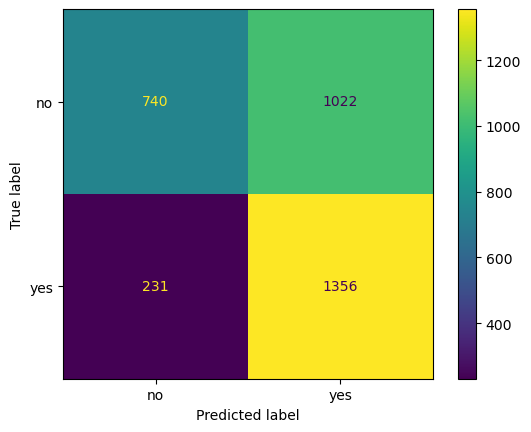

In [71]:
# Cambiamos el umbral de probabilidad a 0.4, como aceptada, para disminuir el número de falsos negativos.

# Elegimos el modelo, cargamos los datos y lo entrenamos.
logr = LogisticRegression (class_weight = 'balanced', random_state = 10, solver = 'liblinear')

logr.fit (Xtrain, ytrain.to_numpy ().ravel())

# Obtenemos un predicción.
# ypred = logr.predict (Xtest)

# Ajustamos la predicción para fijar el 'threshold' a '0.4'.
ypred_th = (logr.predict_proba (Xtest)[:, 1] >= 0.40)
ypred_th = np.where (ypred_th, 'yes', 'no')

print (Xtrain.info ())

# Mostramos diferentes 'scores'.
print ("Accuracy score:   ",   accuracy_score  (ytest, ypred_th))
print ("Precision score:  ",   precision_score (ytest, ypred_th, pos_label = 'yes'))
print ("Recall score:     ",   recall_score    (ytest, ypred_th, pos_label = 'yes'))
print ("f1 score:         ",   f1_score        (ytest, ypred_th, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred_th)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

Al reducir el umbral de probabilidad de 0.5 a 0.4, el número de falsos negativos vuelve a reducirse. 'recall' mejora algo, 'precision' disminuye, pero 'f1' se mantiene.

Thresholds:  [       inf 0.942739   0.93932471 ... 0.08087938 0.07776628 0.00792894]


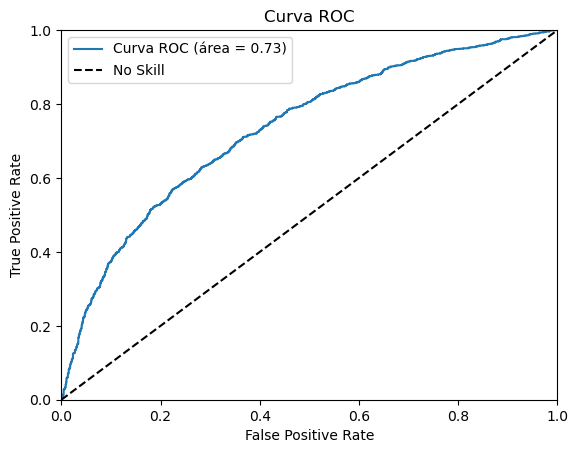

In [73]:
# Dibujamos la curva ROC.

# "logr" ya tiene sus hiperparámetros configurados.
logr.fit (Xtrain, ytrain.to_numpy ().ravel())
yproba = logr.predict_proba (Xtest)

# Cálculo de la curva.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc (fpr, tpr)

print ("Thresholds: ", thresholds)

# Dibujamos la curva.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()

Si se comparan las curvas 'ROC' de las secciones 1.1 y 1.1.3 se comprueba que el area bajo la curva, 0.73 no ha cambiado. Esto significa, que los cambios realizados no cambian la capacidad de predicción del modelo. Sin embargo se ha dismimuido el número de falsos negativos.

1.1.5.- **Mejoras Aplicadas.**

Para mejorar las métricas hemos realizado las pruebas siguientes:

1. Selección de columnas.

Despues de combinar diferentes características, la mejor combinación se obtiene alimentando el modelo con todas las columnas seleccionadas en la sección 6.

2. Cambio en el número de registros de entrenamiento/prueba.

Después de probar diferenctes relaciones entre datos de entrenamiento y datos de prueba la mejor relación está en 70%/30%. Nótese que dicha relación se puede cambiar actualizando el parámetro 'test_size' de la función 'train_test_split' a 0.2, 0.3, 0.4, ...

Dicha función se encuentra en la sección 1 al principo del notebook.

3. Optimización de hiperparámetros.

La función 'GridSearchCV' devuelve los siguientes hiperparámetros como óptimos:

"LogisticRegression(class_weight='balanced', random_state=10, solver='liblinear')"

Dichos hiperparámetros nos disminuyen los falsos negativos, pasando de 504 a 444. Esto es, descartaremos menos llamadas con posibilidades de aceptar el contrato.

4. Validación cruzada.

Una validación cruzada con 10 'folds' muestra unas medias parecidas al caso de la validación con un conjunto de entrenamiento/puebas único. Asímismo la desviación estándar de los escores es relativamente pequeña.

5. Cambio en el umbral de probabilidad del modelo.

Recordemos que umbral de probabilidad es aquel valor de probabilidad del modelo a partir del cual predecimos un valor positivo. Esto es, con una probabilidad igual o superior a (p.e.) 0.4 predecimos que el cliente aceptará el contrato.

Si cambiamos el umbral de probabilidad de 0.5 a 0.4 'recall score' mejora apreciablemente (hasta 0.85), a costa de reducir 'precision score', como se anticipaba. Ello significa que los falsos negativos han disminuido. Por tanto, descartaremos menos llamadas a clientes con probabilidades reales de aceptar el contrato.

6. Comprobación de diferentes tipos de modelos.

A título de ejemplo se muestran en el apartado '1.4.- Anexo. Pruebas con Diferentes Dodelos' diferentes tipos de modelos de clasificación y sus 'scores'. Algunos de dichos modelos mejoran en algo dichos 'scores'. Sin embargo, se escoge la regresión logística por que el número de falsos negativos es sensiblemente inferior.


#### 1.2.- Conclusiones.

En la sección 1.1.1 se han definido y aplicado a nuestro caso las métricas 'accuracy', 'precision', 'recall' y 'F1'. Durante diferentes pruebas se ha visto como dichas métricas podían mejorar, especialmente 'recall', que considera los falsos negativos. Las métricas finalmente obtenidas se resumen aquí:

- Accuracy score:    0.626
- Precision score:   0.570
- Recall score:      0.854
- f1 score:          0.683

Como anticipábamos al mejorar 'recall' (de 0.678 a 0.852), 'precision' ha disminuido algo (de 0.647 a 0.572). 'F1' sin embargo mantiene su valor. Ello significa que las medidas adoptadas reducen los falsos negativos, a la vez que el modelo en su conjunto conserva su capacidad de predicción. Esto es, se reduce el número de llamadas que se predicen negativas aunque tales clientes tuvieran probabilidades de aceptar el contrato, ello supone una ganancia. El número de positivos correctamente predichos de mantiene en un 63%. Las curvas 'ROC' trazadas confirman dicho resultado.

De las diferentes pruebas realizadas en la evaluación del modelo se destacan los siguientes puntos:

1. Se conservan todas las características seleccionadas en la sección 6.
2. La relación datos de entrenamiento/prueba se fija en el 70%/30%
3. La optimización de hiperparámetros nos ha reducido el número de falsos negativos.
4. La validación cruzada nos confirma nuestros resultados.
5. Reducir el umbral de probabilidad a 0.4 reduce los falsos negativos.

Por último debe notarse la presencia de valores 'unknown' en las variables categóricas como 'job', 'education' y, sobre todo, 'contact'. La asignación de dichos valores durante la recolección de los datos, mejorará las diferentes métricas del modelo. La recolección de los datos, recordemos, se realiza durante las propias llamadas en las diferentes campañas de márqueting.


#### 1.3.- Annexo. Creación de los Archivos para el Despliegue.

In [80]:
import pickle

# Guardar el modelo.
with open ('bank_model.pkl', 'wb') as model_file:
    pickle.dump (logr, model_file)

# Guardar el escalador.
with open ('bank_scaler.pkl', 'wb') as scaler_file:
    pickle.dump (scaler, scaler_file)

# Guardar el encoder.
with open ('bank_encoder.pkl', 'wb') as encoder_file:
    pickle.dump (le, encoder_file)


#### 1.4.- Annexo. Pruebas con Diferentes Modelos.

##### 1.4.1.- Gradient Boosting.

Accuracy score:    0.7052851597491788
Precision score:   0.7142857142857143
Recall score:      0.630119722747322
f1 score:          0.6695681285570807


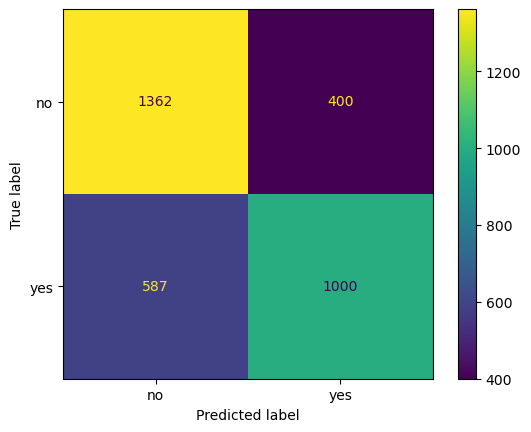

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

gb.fit(Xtrain, ytrain.to_numpy ().ravel())

ypred = gb.predict(Xtest)

# print(classification_report(ytest, ypred))

# Mostramos diferentes 'scores'.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

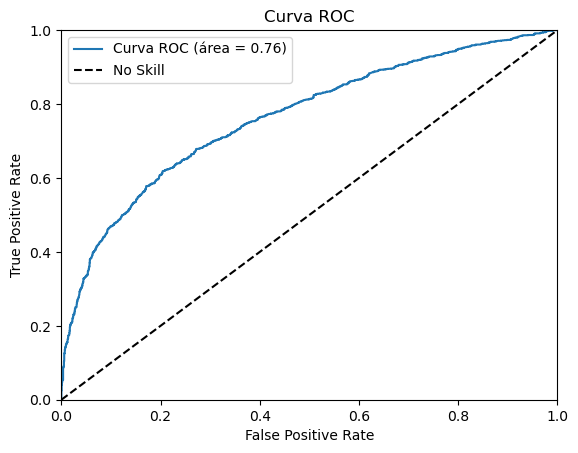

In [84]:
# Dibujamos la curva ROC.

yproba = gb.predict_proba (Xtest)

# Cálculo de la curva.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc(fpr, tpr)

# Dibujamos la curva.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()


##### 1.4.2.- K-Nearest Neighbors (KNN)

Accuracy score:    0.628247237981487
Precision score:   0.6074120603015075
Recall score:      0.6093257718966604
f1 score:          0.6083674111355772


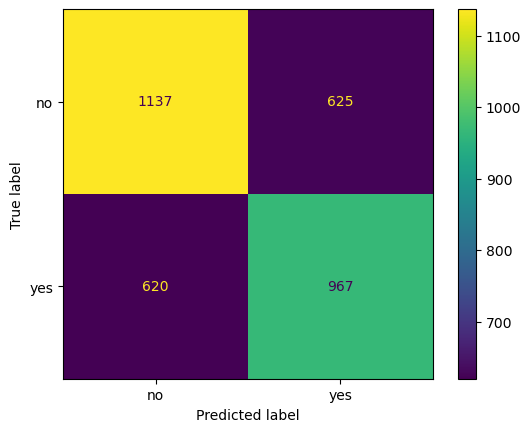

In [86]:
from sklearn.neighbors import KNeighborsClassifier

# Escogemos el modelo.
knn = KNeighborsClassifier (n_neighbors = 3)

knn.fit (Xtrain, ytrain.to_numpy ().ravel())

# Obtenemos nuestra predicción.
ypred = knn.predict (Xtest)

# Mostramos los 'scores'.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()


##### 1.4.3.- Support Vector Machines (SVM)

Accuracy score:    0.6679605852493281
Precision score:   0.6402835203780272
Recall score:      0.6830497794580971
f1 score:          0.6609756097560976


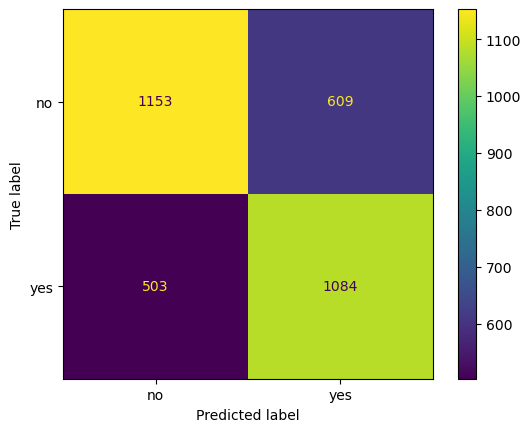

In [88]:
from sklearn.svm import SVC

# Escogemos el modelo.
svm = SVC (kernel = 'linear')

svm.fit (Xtrain, ytrain.to_numpy ().ravel())

# Obtenemos nuestra predicción.
ypred = svm.predict (Xtest)

# Mostramos los 'scores'.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()


##### 1.4.3. Decision Tree.

Accuracy score:    0.6954314720812182
Precision score:   0.7306753458096013
Recall score:      0.5658475110270952
f1 score:          0.6377840909090909


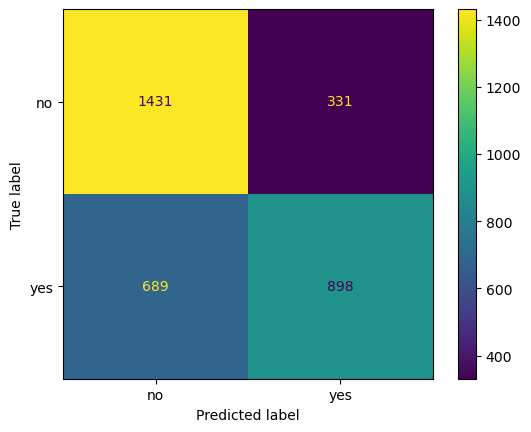

In [90]:
from sklearn.ensemble import RandomForestClassifier

# Escogemos el modelo.
forest = RandomForestClassifier (n_estimators = 100, max_depth = 5, random_state = 42)
forest.fit (Xtrain, ytrain.to_numpy ().ravel())

# Obtenemos nuestra predicción.
ypred = forest.predict (Xtest)

# Mostramos los 'scores'.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()


##### 1.4.4. Random Forest.

Accuracy score:    0.6954314720812182
Precision score:   0.7306753458096013
Recall score:      0.5658475110270952
f1 score:          0.6377840909090909


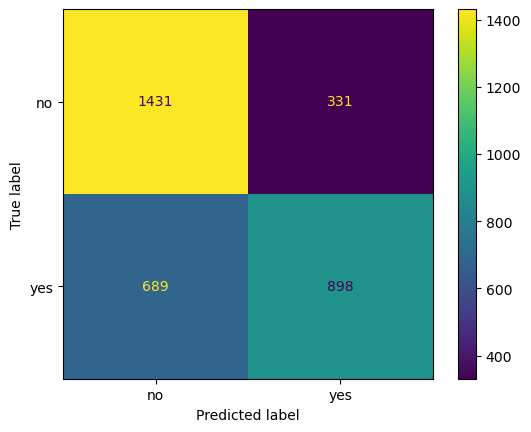

In [92]:
from sklearn.ensemble import RandomForestClassifier

# Escogemos el modelo.
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

forest.fit (Xtrain, ytrain.to_numpy ().ravel())

# Obtenemos nuestra predicción.
ypred = forest.predict (Xtest)

# Mostramos los 'scores'.
print ("Accuracy score:   ",   accuracy_score   (ytest, ypred))
print ("Precision score:  ",   precision_score  (ytest, ypred, pos_label = 'yes'))
print ("Recall score:     ",   recall_score     (ytest, ypred, pos_label = 'yes'))
print ("f1 score:         ",   f1_score         (ytest, ypred, pos_label = 'yes'))

# Mostramos la matriz de confusión.
cm = confusion_matrix (ytest, ypred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['no','yes'])
disp.plot()
plt.show()

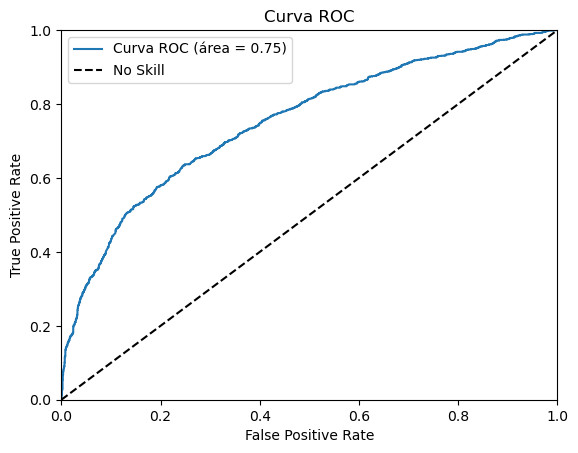

In [93]:
# Dibujamos la curva ROC.

yproba = forest.predict_proba (Xtest)

# Cálculo de la curva.
fpr, tpr, thresholds = roc_curve (ytest, yproba[:, 1], pos_label = 'yes') 
roc_auc = auc(fpr, tpr)

# Dibujamos la curva.
plt.figure ()  
plt.plot (fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot ([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim ([0.0, 1.0])
plt.ylim ([0.0, 1.0])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('Curva ROC')
plt.legend ()
plt.show ()
